In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


# Kütüphaneleri Yükleme ve Veri Keşfi

Bu projede, bir podcastin dinlenme süresini (dakika cinsinden) tahmin etmeye yönelik bir regresyon modeli geliştirdim. Modelin doğruluğunu değerlendirmek için RMSE (Root Mean Squared Error) metriğini kullandım. Bu metriği tercih etmemin nedeni, yarışmayı düzenleyen Kaggle platformunun resmi değerlendirme metriği olarak RMSE’yi belirlemiş olmasıdır. Ayrıca RMSE, büyük tahmin hatalarını daha fazla cezalandırarak modelin performansını hassas biçimde ölçen etkili bir yöntemdir. **Bu projede**:

- Veri ön işleme sürecinde, eksik değerlere müdahale ederken her boş sütun için ek bir _na sütunu oluşturdum. Bu sütunlar, eksik olup olmadığını True/False olarak göstererek modelin bu durumdan öğrenmesini sağladı.
- Ardından aykırı değerleri IQR yöntemini kullanarak tespit edip temizledim.
- Verinin dağılımını daha iyi anlayabilmek için çeşitli görselleştirme tekniklerinden yararlandım.
- Modelleme aşamasında, verileri sayısallaştırarak hem **LinearRegression** hem de **XGBRegressor** algoritmalarını denedim. RMSE skorlarıyla karşılaştırıldığında, XGBRegressor daha başarılı sonuçlar verdiği için final model olarak onu tercih ettim.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train=pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
test=pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

In [4]:
train

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


In [5]:
train.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

# Kayıp Veri

Kayıp verilerin olduğu sütunları ayrıca boş mu dolu mu olduğunu gösteren yeni sütunlar ekledim böylece boş değerleri ortalama ile doldursam bile bu eklediğim yeni sütun ile önceden bu sütunun boş mu yoksa dolu mu olduğunu bileceğim. Bu işlemi yaptıktan sonra orjinal sütunda boş olan değerleri ortalama ile doldurdum. Bu dönüşümleri hem train veri setimde hem de test veri setimde gerçekleştirdim.

In [6]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mean_values_ = {}
        self.columns_with_na_ = []

    def fit(self, X, y=None):
        X = X.copy()
        for col in X.columns:
            if pd.api.types.is_numeric_dtype(X[col]) and X[col].isnull().any():
                self.mean_values_[col] = X[col].mean()
                self.columns_with_na_.append(col)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns_with_na_:
            X[f"{col}_na"] = X[col].isnull()
            X[col] = X[col].fillna(self.mean_values_[col])
        return X


In [7]:
pipeline = Pipeline([
    ('missing_handler', MissingValueHandler())
])

# Yeniden uygula
train_transformed = pipeline.fit_transform(train)
test_transformed = pipeline.transform(test)

In [8]:
train_transformed

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Length_minutes_na,Guest_Popularity_percentage_na,Number_of_Ads_na
0,0,Mystery Matters,Episode 98,64.504738,True Crime,74.81,Thursday,Night,52.236449,0.0,Positive,31.41998,True,True,False
1,1,Joke Junction,Episode 26,119.800000,Comedy,66.95,Saturday,Afternoon,75.950000,2.0,Negative,88.01241,False,False,False
2,2,Study Sessions,Episode 16,73.900000,Education,69.97,Tuesday,Evening,8.970000,0.0,Negative,44.92531,False,False,False
3,3,Digital Digest,Episode 45,67.170000,Technology,57.22,Monday,Morning,78.700000,2.0,Positive,46.27824,False,False,False
4,4,Mind & Body,Episode 86,110.510000,Health,80.07,Monday,Afternoon,58.680000,3.0,Neutral,75.61031,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.660000,Education,69.36,Saturday,Morning,52.236449,0.0,Negative,56.87058,False,True,False
749996,749996,Business Briefs,Episode 21,75.750000,Business,35.21,Saturday,Night,52.236449,2.0,Neutral,45.46242,False,True,False
749997,749997,Lifestyle Lounge,Episode 51,30.980000,Lifestyle,78.58,Thursday,Morning,84.890000,0.0,Negative,15.26000,False,False,False
749998,749998,Style Guide,Episode 47,108.980000,Lifestyle,45.39,Thursday,Morning,93.270000,0.0,Negative,100.72939,False,False,False


In [9]:
train_transformed.isnull().sum()

id                                0
Podcast_Name                      0
Episode_Title                     0
Episode_Length_minutes            0
Genre                             0
Host_Popularity_percentage        0
Publication_Day                   0
Publication_Time                  0
Guest_Popularity_percentage       0
Number_of_Ads                     0
Episode_Sentiment                 0
Listening_Time_minutes            0
Episode_Length_minutes_na         0
Guest_Popularity_percentage_na    0
Number_of_Ads_na                  0
dtype: int64

In [10]:
test_transformed

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Episode_Length_minutes_na,Guest_Popularity_percentage_na,Number_of_Ads_na
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.330000,1.0,Neutral,False,False,False
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,52.236449,0.0,Neutral,False,True,False
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.510000,0.0,Positive,False,False,False
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.750000,2.0,Positive,False,False,False
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.300000,2.0,Neutral,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.400000,3.0,Negative,False,False,False
249996,999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.520000,2.0,Negative,False,False,False
249997,999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.690000,1.0,Neutral,False,False,False
249998,999998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.590000,3.0,Positive,False,False,False


In [11]:
test_transformed.isnull().sum()

id                                0
Podcast_Name                      0
Episode_Title                     0
Episode_Length_minutes            0
Genre                             0
Host_Popularity_percentage        0
Publication_Day                   0
Publication_Time                  0
Guest_Popularity_percentage       0
Number_of_Ads                     0
Episode_Sentiment                 0
Episode_Length_minutes_na         0
Guest_Popularity_percentage_na    0
Number_of_Ads_na                  0
dtype: int64

 # Aykırı Değer 

Projelerde aykırı değer, proje başarısında önemli bir yeri var. Aykırı değer temizliği ile proje başarısını arttırabilirim.

In [12]:
def boxplot_goster(df, col):
    sns.boxplot(x=df[col])
    plt.title(f"{col} Boxplot")
    plt.show()

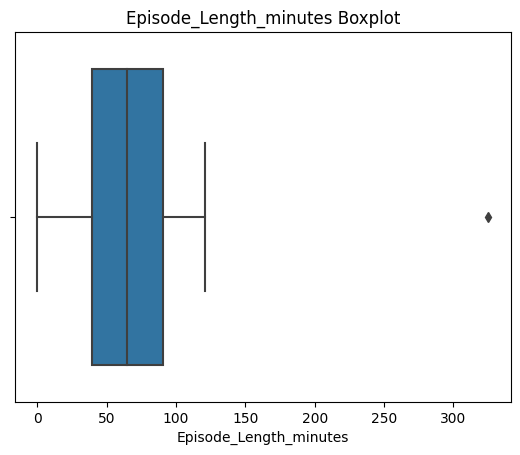

In [13]:
boxplot_goster(train_transformed, "Episode_Length_minutes")

In [14]:
def get_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# 1. Eğitim seti: sınırları hesapla ve temizle
lower, upper = get_iqr_bounds(train_transformed["Episode_Length_minutes"])
train_transformed = train_transformed[
    (train_transformed["Episode_Length_minutes"] >= lower) &
    (train_transformed["Episode_Length_minutes"] <= upper)
]

# 2. Test seti: sadece aykırı değerleri işaretle veya kırp
test_transformed["Episode_Length_minutes"] = np.clip(
    test_transformed["Episode_Length_minutes"], lower, upper
)

# Veri Görselleştirme

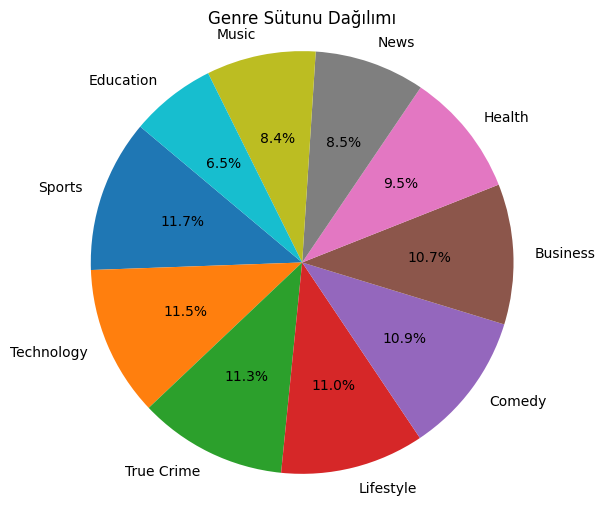

In [15]:
#Hangi türlerde podcast yayınlanıyor ve en çok dinlenen podcast türü ne?

degerler = train_transformed["Genre"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    degerler, 
    labels=degerler.index, 
    autopct='%1.1f%%', 
    startangle=140
)
plt.title("Genre Sütunu Dağılımı")
plt.axis('equal')
plt.show()

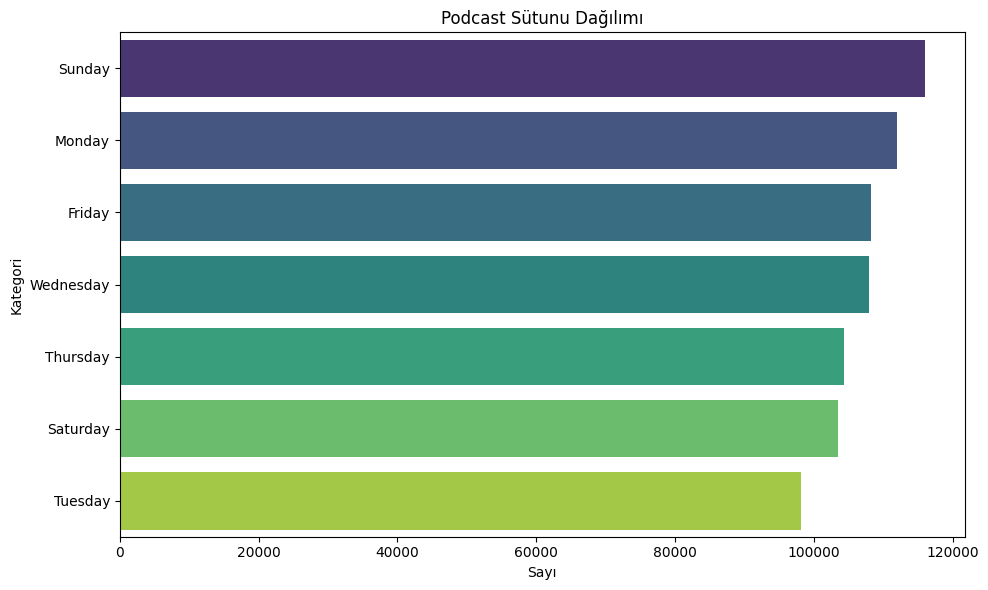

In [16]:
#Podcastlar en çok hangi günde yayınlanıyor?

degerler = train_transformed["Publication_Day"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=degerler.values, y=degerler.index, palette="viridis")
plt.xlabel("Sayı")
plt.ylabel("Kategori")
plt.title("Podcast Sütunu Dağılımı")
plt.tight_layout()
plt.show()

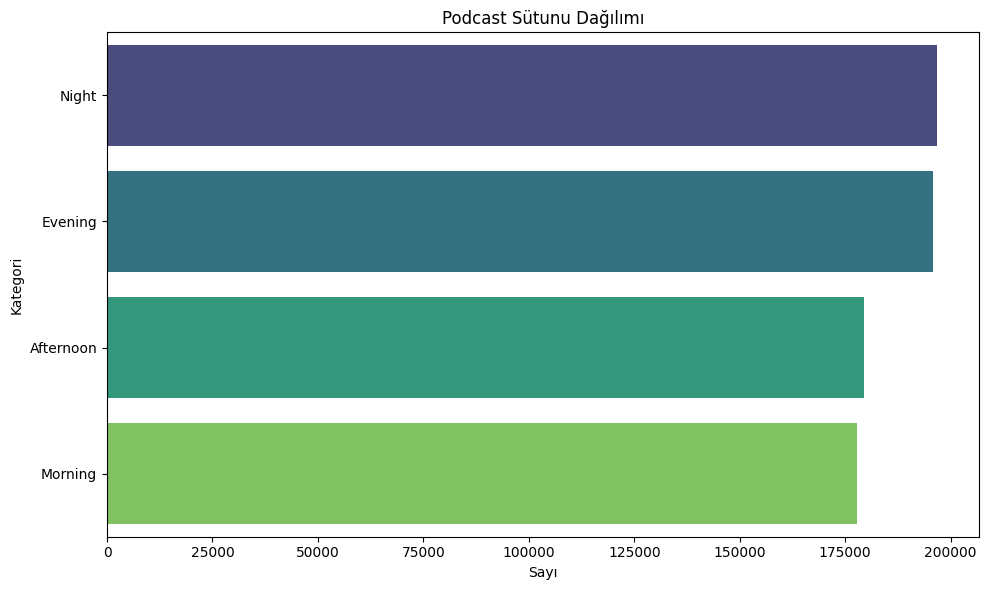

In [17]:
#Podcastlar günün hangi zamanında yayınlanıyor?

degerler = train_transformed["Publication_Time"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=degerler.values, y=degerler.index, palette="viridis")
plt.xlabel("Sayı")
plt.ylabel("Kategori")
plt.title("Podcast Sütunu Dağılımı")
plt.tight_layout()
plt.show()

# Modeller ve Eğitim

Bu proje için 2 model denedim. Modellemeden önce one-hot-encoder ile veri ön işleme yaptım. Kullandığım ilk model Linear Regresyon, bu modelde elde ettiğim doğruluk RMSE skorunu 13.4816 buldum. İkinci model olarak da XGBRegressor kullandım. Bu modelde subsample kullandım ve diğer hiperparametreleri de düzenleyince doğruluk RMSE skorunu 12.9112 elde ettim. 

In [18]:
X = train_transformed.drop("Listening_Time_minutes", axis=1)
y = train_transformed["Listening_Time_minutes"]

In [19]:
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

In [20]:
# Ön işleme (OneHotEncoding)
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
], remainder="passthrough")

# Pipeline: Ön işleme + Model
model = make_pipeline(
    preprocessor,
    LinearRegression()
)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Eğit
model.fit(X_train, y_train)

# Tahmin ve R² hesapla
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 13.4816


In [22]:
model = make_pipeline(
    preprocessor,
    XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1
    )
)

# Eğitim / doğrulama bölme
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Eğitim
model.fit(X_train, y_train)

# Tahmin ve skor
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 12.9112


In [23]:
# Test seti üzerinde tahmin
X_test = test_transformed.copy()
test_preds = model.predict(X_test)

# Submission dosyasını hazırla
submission = pd.read_csv("/kaggle/input/playground-series-s5e4/sample_submission.csv")
submission["Listening_Time_minutes"] = test_preds
submission.to_csv("submission.csv", index=False)